In [ ]:
from google.colab import drive
drive.mount('/content/drive/' )

Mounted at /content/drive/


In [ ]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import numpy as np
import xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sn

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Statistique sur le dataset

**load the data**

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/kaggle-nabil-badri/olid-training-v1.0.tsv", sep='\t',error_bad_lines=False)
print(data.head())
X_test=pd.read_csv('/content/drive/MyDrive/kaggle-nabil-badri/testset-levela.tsv',sep="\t")
y_test=pd.read_csv( '/content/drive/MyDrive/kaggle-nabil-badri/labels-levela.csv',header=None).iloc[:,-1]

      id                                              tweet  ... subtask_b subtask_c
0  86426  @USER She should ask a few native Americans wh...  ...       UNT       NaN
1  90194  @USER @USER Go home you’re drunk!!! @USER #MAG...  ...       TIN       IND
2  16820  Amazon is investigating Chinese employees who ...  ...       NaN       NaN
3  62688  @USER Someone should'veTaken" this piece of sh...  ...       UNT       NaN
4  43605  @USER @USER Obama wanted liberals &amp; illega...  ...       NaN       NaN

[5 rows x 5 columns]


In [ ]:
trainDF = pd.DataFrame()
trainDF['text'] = data['tweet']
trainDF['label'] = data['subtask_a'] #  change data["subtask_a"] to  data["subtask_b"]
trainDF.head()

,text,label
0,@USER She should ask a few native Americans wh...,OFF
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF
2,Amazon is investigating Chinese employees who ...,NOT
3,"@USER Someone should'veTaken"" this piece of sh...",OFF
4,@USER @USER Obama wanted liberals &amp; illega...,NOT


In [ ]:
#train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'])
train_x=trainDF['text']
train_y=trainDF['label']
valid_x=X_test['tweet']
print('training on    : ' ,len(train_x))
print('validating on  : ' ,len(valid_x))
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(y_test)

training on    :  13240
validating on  :  860


In [ ]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(trainDF['text'])
 
# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

In [ ]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(trainDF['text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)
 
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(trainDF['text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)
 
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(trainDF['text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [ ]:
# train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)
X_topics = lda_model.fit_transform(xtrain_count)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()
 
# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = numpy.array(vocab)[numpy.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

In [ ]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=1)
        classification_rep = classification_report(valid_y,predictions, target_names=(["not offensive","offensive"]))
    else :
      classification_rep = classification_report(valid_y,predictions, target_names=(["not offensive","offensive"]))
    return (metrics.accuracy_score(valid_y, predictions), metrics.f1_score(valid_y, predictions, average='macro'), 
            metrics.recall_score(valid_y, predictions), metrics.precision_score(valid_y, predictions),
            metrics.confusion_matrix(valid_y, predictions), classification_rep)


In [ ]:
def result_vis(result):
  width = 0.5
  labels = list(result.keys())
  accuracy = []
  f1_score = []
  recall = []
  precision = []
  for label in labels :
    print("[INFO] Metrics for : ", label)
    print("Accuracy_______:  ",result[label]['accuracy'])
    print("F1_score_______:  ",result[label]['f1_score'])
    print("Recall_________:  ",result[label]['recall'])
    print("Precision______:  ",result[label]['precision'])
    print("classification report :")
    print(result[label]['report'])
    df_cm = pd.DataFrame(result[label]["confusion_matrix"], range(2), range(2))
    df_cm.rename(columns={"A": "Offensive", "B": "Not Offensive"})
    df_cm.rename(index={"A": "Offensive", "B": "Not Offensive"})
    sn.set(font_scale=1) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt="d", xticklabels=['Offensive','Not Offensive'], yticklabels=['Offensive','Not Offensive']) # font size
    plt.show()


    accuracy.append(result[label]['accuracy'])
    f1_score.append(result[label]['f1_score'])
    recall.append(result[label]['recall'])
    precision.append(result[label]['precision'])
  X = np.arange(len(labels))
  fig = plt.figure()
  fig.set_size_inches(8,5)
  ax = fig.add_axes([0,0,1,1])
  rect1 = ax.bar(X + 0.00,accuracy, color = 'b', width = 0.20)
  rect2 = ax.bar(X + 0.20, f1_score, color = 'g', width = 0.20)
  rect3 = ax.bar(X + 0.40, recall , color = 'r', width = 0.20)
  rect4 = ax.bar(X + 0.60, precision , color = (1, 0, 1), width = 0.20)

  ax.set_ylabel('Scores')
  ax.set_title('metrics')
  ax.set_xlabel(labels)
  def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

  autolabel(rect1)
  autolabel(rect2)
  autolabel(rect3)
  autolabel(rect4)
  ax.set_xticks([r + 0.25 / 2 for r in range(len(labels))],labels)
  ax.legend(labels=['accuracy', 'f1_score', 'recall', 'precision'],loc='best')
  plt.ylim(0, 1)


In [ ]:
from sklearn.model_selection import GridSearchCV


NB, WordLevel TF-IDF:  (0.7767441860465116, 0.6144182179919484, 0.22916666666666666, 0.8870967741935484, array([[613,   7],
       [185,  55]]), '               precision    recall  f1-score   support\n\nnot offensive       0.77      0.99      0.86       620\n    offensive       0.89      0.23      0.36       240\n\n     accuracy                           0.78       860\n    macro avg       0.83      0.61      0.61       860\n weighted avg       0.80      0.78      0.72       860\n')
NB, N-Gram Vectors:  (0.7453488372093023, 0.5658277834256589, 0.18333333333333332, 0.6567164179104478, array([[597,  23],
       [196,  44]]), '               precision    recall  f1-score   support\n\nnot offensive       0.75      0.96      0.85       620\n    offensive       0.66      0.18      0.29       240\n\n     accuracy                           0.75       860\n    macro avg       0.70      0.57      0.57       860\n weighted avg       0.73      0.75      0.69       860\n')
NB, CharLevel Vectors:  

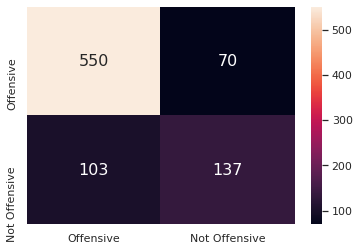

[INFO] Metrics for :  navie_bayes_TF-IDF
Accuracy_______:   0.78
F1_score_______:   0.61
Recall_________:   0.23
Precision______:   0.89
classification report :
               precision    recall  f1-score   support

not offensive       0.77      0.99      0.86       620
    offensive       0.89      0.23      0.36       240

     accuracy                           0.78       860
    macro avg       0.83      0.61      0.61       860
 weighted avg       0.80      0.78      0.72       860



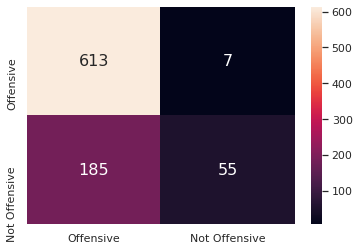

[INFO] Metrics for :  navie_bayes_N-Gram_Vectors
Accuracy_______:   0.75
F1_score_______:   0.57
Recall_________:   0.18
Precision______:   0.66
classification report :
               precision    recall  f1-score   support

not offensive       0.75      0.96      0.85       620
    offensive       0.66      0.18      0.29       240

     accuracy                           0.75       860
    macro avg       0.70      0.57      0.57       860
 weighted avg       0.73      0.75      0.69       860



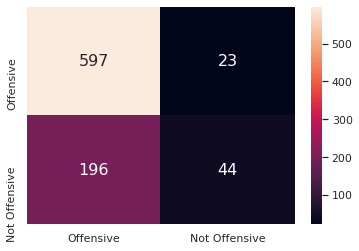

[INFO] Metrics for :  navie_bayes_CharLevel Vectors
Accuracy_______:   0.77
F1_score_______:   0.6
Recall_________:   0.22
Precision______:   0.81
classification report :
               precision    recall  f1-score   support

not offensive       0.76      0.98      0.86       620
    offensive       0.81      0.22      0.34       240

     accuracy                           0.77       860
    macro avg       0.79      0.60      0.60       860
 weighted avg       0.78      0.77      0.71       860



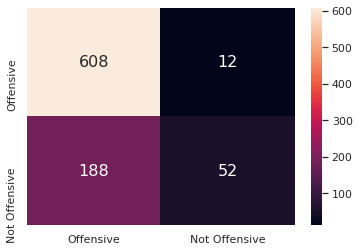

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


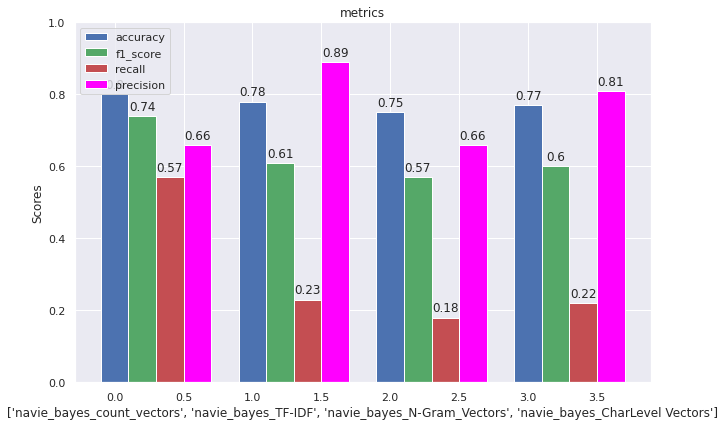

In [ ]:
# Naive Bayes on Count Vectors
result = {}
metric = train_model(naive_bayes.MultinomialNB(alpha=1.0), xtrain_count, train_y, xvalid_count )
# Naive Bayes on Word Level TF IDF Vectors
result["navie_bayes_count_vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                       "precision":round(metric[3], 2), "confusion_matrix":metric[4], "report": metric[5]}
metric = train_model(naive_bayes.MultinomialNB(alpha=1.0), xtrain_tfidf, train_y, xvalid_tfidf)
print ("NB, WordLevel TF-IDF: ", metric)
result["navie_bayes_TF-IDF"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                "precision":round(metric[3], 2), "confusion_matrix":metric[4], "report": metric[5]}
# Naive Bayes on Ngram Level TF IDF Vectors
metric = train_model(naive_bayes.MultinomialNB(alpha=1.0), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("NB, N-Gram Vectors: ", metric)
result["navie_bayes_N-Gram_Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                        "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}

# Naive Bayes on Character Level TF IDF Vectors
metric = train_model(naive_bayes.MultinomialNB(alpha=1.0), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars )
print ("NB, CharLevel Vectors: ", metric)
result["navie_bayes_CharLevel Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                           "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}
result_vis(result)


In [ ]:
param={'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}

[INFO] Metrics for :  LR, Count Vectors
Accuracy_______:   0.81
F1_score_______:   0.73
Recall_________:   0.5
Precision______:   0.72
classification report :
               precision    recall  f1-score   support

not offensive       0.83      0.93      0.87       620
    offensive       0.72      0.50      0.59       240

     accuracy                           0.81       860
    macro avg       0.77      0.71      0.73       860
 weighted avg       0.80      0.81      0.79       860



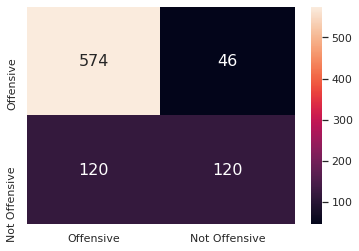

[INFO] Metrics for :  LR, WordLevel TF-IDF
Accuracy_______:   0.82
F1_score_______:   0.73
Recall_________:   0.44
Precision______:   0.82
classification report :
               precision    recall  f1-score   support

not offensive       0.82      0.96      0.88       620
    offensive       0.82      0.44      0.57       240

     accuracy                           0.82       860
    macro avg       0.82      0.70      0.73       860
 weighted avg       0.82      0.82      0.80       860



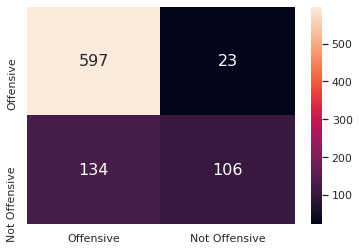

[INFO] Metrics for :  LR, N-Gram Vectors
Accuracy_______:   0.74
F1_score_______:   0.58
Recall_________:   0.2
Precision______:   0.63
classification report :
               precision    recall  f1-score   support

not offensive       0.76      0.95      0.84       620
    offensive       0.63      0.20      0.31       240

     accuracy                           0.74       860
    macro avg       0.69      0.58      0.58       860
 weighted avg       0.72      0.74      0.69       860



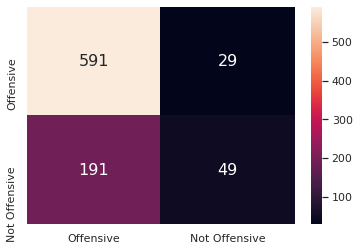

[INFO] Metrics for :  LR, CharLevel Vectors
Accuracy_______:   0.81
F1_score_______:   0.72
Recall_________:   0.44
Precision______:   0.77
classification report :
               precision    recall  f1-score   support

not offensive       0.81      0.95      0.88       620
    offensive       0.77      0.44      0.56       240

     accuracy                           0.81       860
    macro avg       0.79      0.69      0.72       860
 weighted avg       0.80      0.81      0.79       860



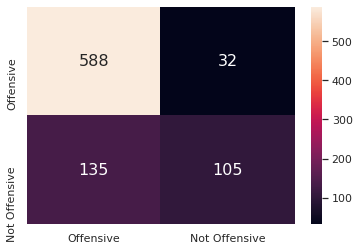

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


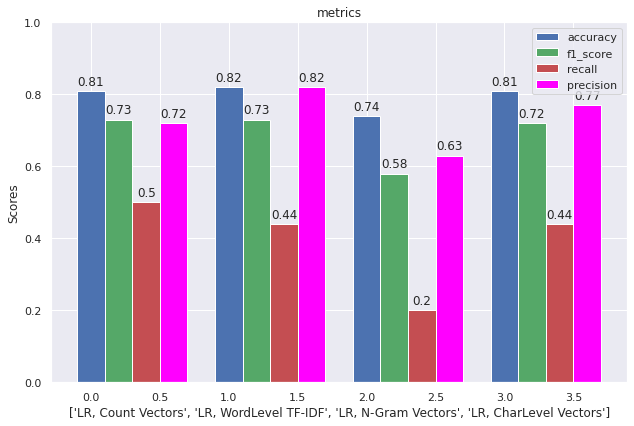

In [ ]:
result.clear()
# Linear Classifier on Count Vectors
metric = train_model(linear_model.LogisticRegression(**param), xtrain_count, train_y, xvalid_count)
result["LR, Count Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                               "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}
# Linear Classifier on Word Level TF IDF Vectors
metric = train_model(linear_model.LogisticRegression(**param), xtrain_tfidf, train_y, xvalid_tfidf)

result["LR, WordLevel TF-IDF"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                  "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}

# Linear Classifier on Ngram Level TF IDF Vectors
metric = train_model(linear_model.LogisticRegression(**param), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)

result["LR, N-Gram Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}

# Linear Classifier on Character Level TF IDF Vectors
metric = train_model(linear_model.LogisticRegression(**param), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)

result["LR, CharLevel Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                   "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}
result_vis(result)
result.clear()

SVM, N-Gram Vectors:  (0.7116279069767442, 0.5917648590088124, 0.30416666666666664, 0.474025974025974, array([[539,  81],
       [167,  73]]), '               precision    recall  f1-score   support\n\nnot offensive       0.76      0.87      0.81       620\n    offensive       0.47      0.30      0.37       240\n\n     accuracy                           0.71       860\n    macro avg       0.62      0.59      0.59       860\n weighted avg       0.68      0.71      0.69       860\n')
NB, CharLevel Vectors:  (0.7930232558139535, 0.7100757575757576, 0.4625, 0.69375, array([[571,  49],
       [129, 111]]), '               precision    recall  f1-score   support\n\nnot offensive       0.82      0.92      0.87       620\n    offensive       0.69      0.46      0.56       240\n\n     accuracy                           0.79       860\n    macro avg       0.75      0.69      0.71       860\n weighted avg       0.78      0.79      0.78       860\n')
[INFO] Metrics for :  SVM, Count Vectors
Accura

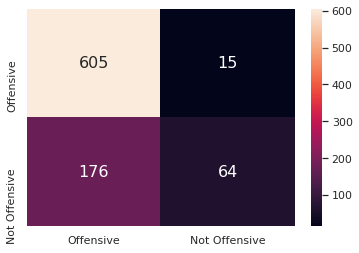

[INFO] Metrics for :  SVM, WordLevel TF-IDF
Accuracy_______:   0.81
F1_score_______:   0.73
Recall_________:   0.48
Precision______:   0.75
classification report :
               precision    recall  f1-score   support

not offensive       0.82      0.94      0.88       620
    offensive       0.75      0.48      0.59       240

     accuracy                           0.81       860
    macro avg       0.79      0.71      0.73       860
 weighted avg       0.80      0.81      0.80       860



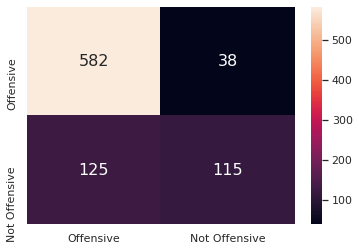

[INFO] Metrics for :  SVM N-Gram_Vectors
Accuracy_______:   0.71
F1_score_______:   0.59
Recall_________:   0.3
Precision______:   0.47
classification report :
               precision    recall  f1-score   support

not offensive       0.76      0.87      0.81       620
    offensive       0.47      0.30      0.37       240

     accuracy                           0.71       860
    macro avg       0.62      0.59      0.59       860
 weighted avg       0.68      0.71      0.69       860



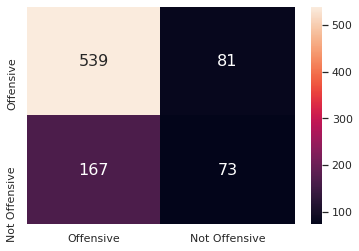

[INFO] Metrics for :  SVM CharLevel Vectors
Accuracy_______:   0.79
F1_score_______:   0.71
Recall_________:   0.46
Precision______:   0.69
classification report :
               precision    recall  f1-score   support

not offensive       0.82      0.92      0.87       620
    offensive       0.69      0.46      0.56       240

     accuracy                           0.79       860
    macro avg       0.75      0.69      0.71       860
 weighted avg       0.78      0.79      0.78       860



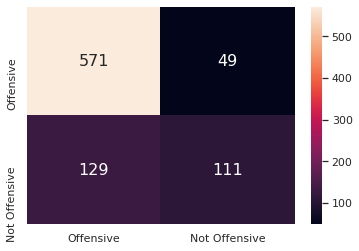

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


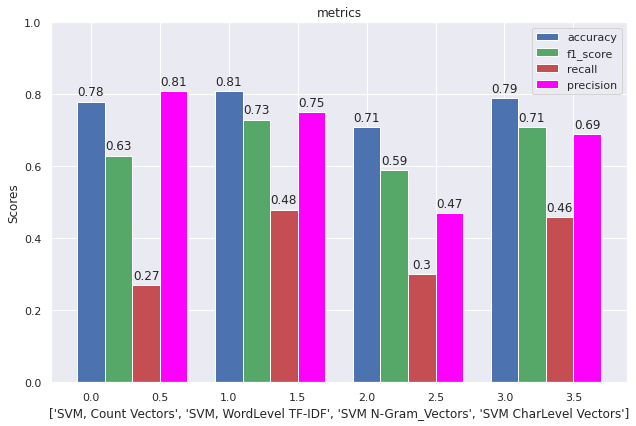

In [ ]:
result = {}
# SVM on Word Level Count Vectors

metric = train_model(svm.SVC(**{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}), xtrain_count, train_y, xvalid_count)

result["SVM, Count Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                               "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}
# SVM on Word Level TF IDF Vectors
metric = train_model(svm.SVC(**{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}), xtrain_tfidf, train_y, xvalid_tfidf)

result["SVM, WordLevel TF-IDF"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                  "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}
                              
# SVM on Ngram Level TF IDF Vectors
metric = train_model(svm.SVC(**{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("SVM, N-Gram Vectors: ", metric)
result["SVM N-Gram_Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                        "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}

# SVM on Character Level TF IDF Vectors
metric = train_model(svm.SVC(**{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars )
print ("NB, CharLevel Vectors: ", metric)
result["SVM CharLevel Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                           "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}

result_vis(result)
result.clear()

[INFO] Metrics for :  RF, Count Vectors
Accuracy_______:   0.79
F1_score_______:   0.71
Recall_________:   0.46
Precision______:   0.69
classification report :
               precision    recall  f1-score   support

not offensive       0.82      0.92      0.87       620
    offensive       0.69      0.46      0.56       240

     accuracy                           0.79       860
    macro avg       0.75      0.69      0.71       860
 weighted avg       0.78      0.79      0.78       860



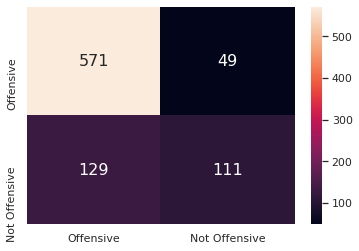

[INFO] Metrics for :  RF, WordLevel TF-IDF
Accuracy_______:   0.79
F1_score_______:   0.71
Recall_________:   0.46
Precision______:   0.69
classification report :
               precision    recall  f1-score   support

not offensive       0.82      0.92      0.87       620
    offensive       0.69      0.46      0.56       240

     accuracy                           0.79       860
    macro avg       0.75      0.69      0.71       860
 weighted avg       0.78      0.79      0.78       860



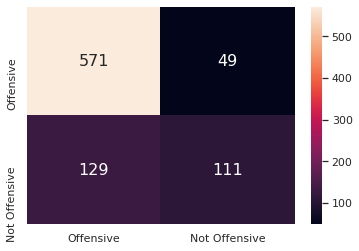

[INFO] Metrics for :  RF, N-Gram Vectors
Accuracy_______:   0.74
F1_score_______:   0.59
Recall_________:   0.25
Precision______:   0.58
classification report :
               precision    recall  f1-score   support

not offensive       0.76      0.93      0.84       620
    offensive       0.58      0.25      0.35       240

     accuracy                           0.74       860
    macro avg       0.67      0.59      0.59       860
 weighted avg       0.71      0.74      0.70       860



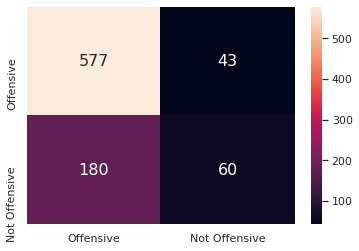

[INFO] Metrics for :  RF, CharLevel Vectors
Accuracy_______:   0.79
F1_score_______:   0.65
Recall_________:   0.28
Precision______:   0.85
classification report :
               precision    recall  f1-score   support

not offensive       0.78      0.98      0.87       620
    offensive       0.85      0.28      0.42       240

     accuracy                           0.79       860
    macro avg       0.81      0.63      0.65       860
 weighted avg       0.80      0.79      0.74       860



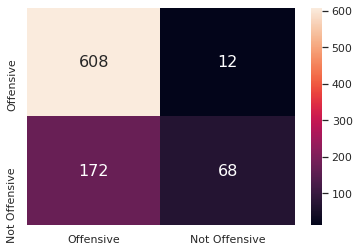

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


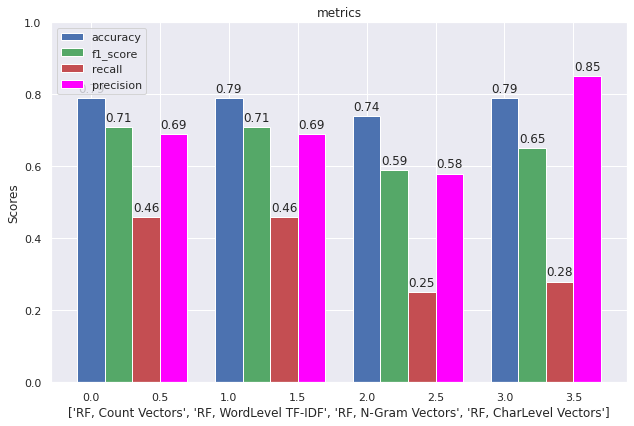

In [ ]:
# RF on Count Vectors
result = {}
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
result["RF, Count Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                               "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}
# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
result["RF, WordLevel TF-IDF"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                  "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}

# RF on Ngram Level TF IDF Vectors
metric = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)

result["RF, N-Gram Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}

# RF on Character Level TF IDF Vectors
metric = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)

result["RF, CharLevel Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                   "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}

result_vis(result)
result.clear()

In [ ]:
params={'colsample_bytree': 0.8,
 'gamma': 1,
 'max_depth': 4,
 'min_child_weight': 1,
 'subsample': 0.8}

[INFO] Metrics for :  Xgb, Count Vectors
Accuracy_______:   0.79
F1_score_______:   0.65
Recall_________:   0.29
Precision______:   0.85
classification report :
               precision    recall  f1-score   support

not offensive       0.78      0.98      0.87       620
    offensive       0.85      0.29      0.43       240

     accuracy                           0.79       860
    macro avg       0.82      0.64      0.65       860
 weighted avg       0.80      0.79      0.75       860



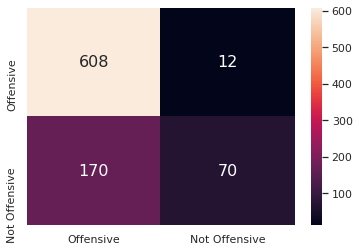

[INFO] Metrics for :  Xgb, WordLevel TF-IDF
Accuracy_______:   0.79
F1_score_______:   0.65
Recall_________:   0.28
Precision______:   0.87
classification report :
               precision    recall  f1-score   support

not offensive       0.78      0.98      0.87       620
    offensive       0.87      0.28      0.42       240

     accuracy                           0.79       860
    macro avg       0.82      0.63      0.65       860
 weighted avg       0.80      0.79      0.74       860



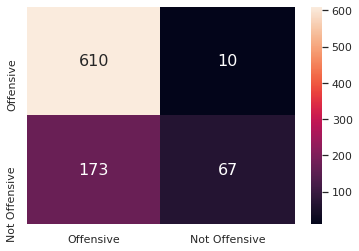

[INFO] Metrics for :  Xgb, CharLevel Vectors
Accuracy_______:   0.79
F1_score_______:   0.68
Recall_________:   0.38
Precision______:   0.73
classification report :
               precision    recall  f1-score   support

not offensive       0.80      0.95      0.86       620
    offensive       0.73      0.38      0.49       240

     accuracy                           0.79       860
    macro avg       0.76      0.66      0.68       860
 weighted avg       0.78      0.79      0.76       860



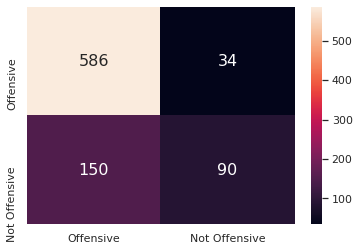

[INFO] Metrics for :  RF, N-Gram Vectors
Accuracy_______:   0.73
F1_score_______:   0.47
Recall_________:   0.06
Precision______:   0.7
classification report :
               precision    recall  f1-score   support

not offensive       0.73      0.99      0.84       620
    offensive       0.70      0.06      0.11       240

     accuracy                           0.73       860
    macro avg       0.72      0.52      0.47       860
 weighted avg       0.72      0.73      0.64       860



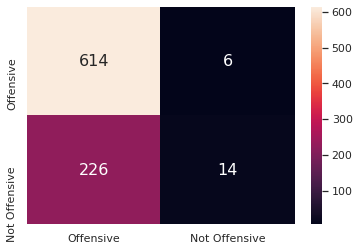

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


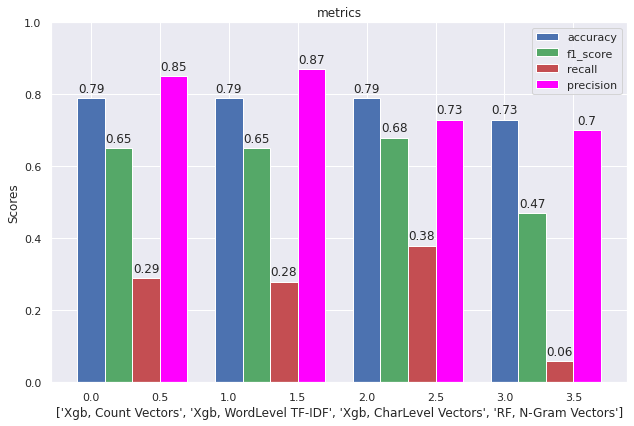

In [ ]:
metric = train_model(xgboost.XGBClassifier(**params), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
result["Xgb, Count Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}

# Extereme Gradient Boosting on Word Level TF IDF Vectors
metric = train_model(xgboost.XGBClassifier(**params), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
result["Xgb, WordLevel TF-IDF"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                   "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}

# Extereme Gradient Boosting on Character Level TF IDF Vectors
metric = train_model(xgboost.XGBClassifier(**params), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
result["Xgb, CharLevel Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                    "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}

# xgb on Ngram Level TF IDF Vectors
metric = train_model(xgboost.XGBClassifier(**params), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
result["xgb, N-Gram Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}
result_vis(result)
result.clear()